##### Overview

This notebook imports raw ws3 input data, reformats and monkey-patches the data, and exports Woodstock formatted input data files (which we will use in other DSS notebooks for this case as the input data files). 

# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import csv
import numpy as np
import time
from functools import partial, wraps
import distance
import operator
import shutil
import os
import math

Define some key model parameters (will get used but defined here up top for convenience).

In [3]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
n_steps = 100
tvy_name = 'totvol'

Define paths required in the code to read and write

In [4]:
# Input paths
# shapefile_path = './data/shp_files/tsa17.shp/stands selection.shp'
shapefile_path = './data/shp_files/tsa07.shp/stands.shp'
# Output paths
stands_csv_path = './data/stands.csv'
curve_points_table_csv_path = './data/curve_points_table.csv'

yldmerged_csv_path = './data/yldmerged.csv'

woodstock_model_files_lan_path = './data/woodstock_model_files_ecotrust/ecotrust.lan'
woodstock_model_files_are_path = './data/woodstock_model_files_ecotrust/ecotrust.are'
woodstock_model_files_yld_path = './data/woodstock_model_files_ecotrust/ecotrust.yld'
woodstock_model_files_act_path = './data/woodstock_model_files_ecotrust/ecotrust.act'
woodstock_model_files_trn_path = './data/woodstock_model_files_ecotrust/ecotrust.trn'
contributing_area_path = './data/woodstock_model_files_ecotrust/aoi.txt'

# Import and reformat inventory and yield input data

Read forest inventory data into memory (vector polygon GIS data layer with attribute table, in ESRI Shapefile format). This dataset represents timber supply area (TSA) in British Columbia. We monkey-patch the inventory data here to make it line up nicely with what we need downstream as input for the ws3 model (i.e., changes we make here to the in-memory dataset are not saved to the original dataset on disk). Most of what we are doing here is setting up the _theme_ columns in the attribute table, which should help newer ws3 users make the connection between input data and the landscape themes in ws3 model further down.

In [5]:
stands_org = gpd.read_file(shapefile_path)


In [6]:
stands_org['forest_type'] = stands_org.apply(
    lambda row: 1 if row['age2015'] > (60 + 10) else 2,
    axis=1
)
stands_org

,theme0,thlb,au,ldspp,age2015,shape_area,geometry,forest_type
0,tsa07,0,307,Spruce,259,1.743311e-05,"POLYGON ((1583753.719 710741.804, 1583748.138 ...",1
1,tsa07,0,265,Subalpine fir,129,4.491693e-05,"POLYGON ((1592710.365 711152.021, 1592766.603 ...",1
2,tsa07,0,265,Subalpine fir,129,2.738030e-05,"POLYGON ((1593276.858 711863.905, 1593291.692 ...",1
3,tsa07,0,1103,Spruce,309,4.785272e-05,"POLYGON ((1608527.073 712887.751, 1608493.143 ...",1
4,tsa07,0,307,Spruce,149,5.226042e-06,"POLYGON ((1609005.906 710787.745, 1609033.035 ...",1
...,...,...,...,...,...,...,...,...
56043,tsa07,0,588,Douglas-fir,139,3.181238e-04,"POLYGON ((1662294.566 725411.378, 1662328.637 ...",1
56044,tsa07,0,312,Engelmann spruce,144,3.391905e-06,"POLYGON ((1665758.542 724827.368, 1665749.284 ...",1
56045,tsa07,0,379,Lodgepole pine,69,1.039119e-05,"POLYGON ((1658907.959 724356.668, 1658900.051 ...",2
56046,tsa07,0,328,Poplar,74,3.003634e-08,"POLYGON ((1641895.759 723292.489, 1641896.951 ...",1


Import CANFI tree species lookup table (associates tree species names with integer numerical values, which we use as theme data values in the ws3 model), and insert species code values into the yield curve dataframe.

In [7]:
columns_to_keep = ['theme0', 'thlb', 'au', 'ldspp', 'age2015', 'shape_area', 'geometry','forest_type']
stands = stands_org[columns_to_keep].copy()
# stands['theme0'] = 'tsa01'
columns = ['theme0'] + \
          [col for col in stands.columns if col not in ['theme0', 'forest_type']]  # Exclude these two
columns.insert(4, 'forest_type')  # Insert 'primary_forest' at the 4th position
stands = stands[columns]  # Apply new order

In [8]:
stands = stands.rename(columns={'thlb': 'theme1', 'au': 'theme2', 'ldspp': 'theme3', 'forest_type': 'theme5', 'age2015': 'age', 'shape_area': 'area' })

In [9]:
stands['area'] = stands.geometry.area * 0.0001
# This code changes the type of "theme2" into integer
stands['theme2'] = stands['theme2'].astype(int)
# stands = ensure_missing_values(stands)
stands.insert(4, 'theme4', stands['theme2'])
stands

,theme0,theme1,theme2,theme3,theme4,theme5,age,area,geometry
0,tsa07,0,307,Spruce,307,1,259,13.585706,"POLYGON ((1583753.719 710741.804, 1583748.138 ..."
1,tsa07,0,265,Subalpine fir,265,1,129,35.007958,"POLYGON ((1592710.365 711152.021, 1592766.603 ..."
2,tsa07,0,265,Subalpine fir,265,1,129,21.337668,"POLYGON ((1593276.858 711863.905, 1593291.692 ..."
3,tsa07,0,1103,Spruce,1103,1,309,37.293833,"POLYGON ((1608527.073 712887.751, 1608493.143 ..."
4,tsa07,0,307,Spruce,307,1,149,4.074927,"POLYGON ((1609005.906 710787.745, 1609033.035 ..."
...,...,...,...,...,...,...,...,...,...
56043,tsa07,0,588,Douglas-fir,588,1,139,247.746705,"POLYGON ((1662294.566 725411.378, 1662328.637 ..."
56044,tsa07,0,312,Engelmann spruce,312,1,144,2.641290,"POLYGON ((1665758.542 724827.368, 1665749.284 ..."
56045,tsa07,0,379,Lodgepole pine,379,2,69,8.091608,"POLYGON ((1658907.959 724356.668, 1658900.051 ..."
56046,tsa07,0,328,Poplar,328,1,74,0.023384,"POLYGON ((1641895.759 723292.489, 1641896.951 ..."


Read yield data from a CSV file and recast AU column data type to integer.

In [10]:
# Reading yld table and changing AU column type into integer
yld = pd.read_csv('./data/yld.csv')
yld['AU'] = yld['AU'].astype(int)


Create analysis unit (AU) dataframe from stands dataframe data.

In [11]:
# Creating AU table from stands table and renaming the column to AU. The AU table is then joined with yld table.
AU = pd.DataFrame(stands['theme2']).drop_duplicates()
AU.rename(columns = {'theme2':'AU'},inplace=True)

In [12]:
# Inner joining AU and yld tables. The results of the code will be a yield table (yldmerged) that has AU column.
yldmerged = pd.merge(AU, yld, on=['AU'], how='inner')

Import CANFI tree species lookup table (associates tree species names with integer numerical values, which we use as theme data values in the ws3 model), and insert species code values into the yield curve dataframe.

In [13]:
# Getting names and codes of canfi_species. This table will be used to add canfi_species column into yldmerged
canf = pd.read_csv('data/canfi_species_revised.csv')
canf = canf[['name','canfi_species']].set_index('name')

Burn CANFI species codes into stand and yield data tables.

In [14]:
yldmerged['canfi_species'] = yldmerged.apply(lambda row: canf.loc[row['LDSPP'], 'canfi_species'], axis=1)

In [15]:
# replacing leading species names with their codes
for index, row in stands.iterrows():
    stands.at[index,'theme6'] = canf.loc[row['theme3'],'canfi_species']
stands['theme3'] = stands['theme6']
# stands = stands.drop('theme6',axis=1)
# stands['theme4'] = stands['theme2']
stands['theme3'] = stands['theme3'] .astype(int)

In [16]:
# stands = ensure_missing_values(stands)
# stands.insert(5, 'theme5', stands['theme4'])
total_area = stands[stands['theme1'] == 1]['area'].sum()


In [17]:
curve_points_table = yldmerged
# Adding 'curve_id' and 'canfi_species' columns to curve_points_table
curve_points_table ['curve_id'] = curve_points_table ['AU']
curve_points_table ['canfi_species'] = yldmerged ['canfi_species'].astype(int)

In [18]:
columns_to_index_yld = ['AU']

In [19]:
curve_points_table = curve_points_table.set_index(columns_to_index_yld)

Save reformatted data to CSV files. 

In [20]:
# stands_.to_csv(stands_csv_path, index=False)
# stands_mdf.to_csv(stands_mdf_csv_path, index=False)
# yld_vdyp.to_csv(yld_vdyp_csv_path, index=False)
yldmerged.to_csv(yldmerged_csv_path, header=True, index=False)
stands.to_csv(stands_csv_path, header=True, index=False)
curve_points_table.to_csv(curve_points_table_csv_path, header=True, index=False)

In [21]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # AUs
            'theme3', # leading species code
            'theme4',  # yield curve ID
            'theme5',  # forest type
           ]
basecodes = [list(map(lambda x: str(x), stands[tc].unique())) for tc in theme_cols]
basecodes[2] = list(set(basecodes[2] + list(stands['theme2'].astype(str))))
basecodes[3] = list(set(basecodes[3] + list(stands['theme3'].astype(str))))
# basecodes[4] = list(set(basecodes[4] + list((stands['theme2'] * 1000 + 1).astype(str)) + list((stands['theme2'] * 1000 + 2).astype(str))))
basecodes[4] = list(set(basecodes[4] + list(stands['theme4'].astype(str))))
basecodes[5] = list(set(basecodes[5] + list(stands['theme5'].astype(str))))

In [22]:
fm = ws3.forest.ForestModel(model_name='ecotest',
                            model_path='data',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [23]:
for ti, t in enumerate(theme_cols):
    fm.add_theme(t, basecodes[ti])

In [24]:
gstands = stands.groupby(theme_cols+['age'])

In [25]:
age_cutoff = 600
for name, group in gstands:
    dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
    if dtk not in fm.dtypes:
        fm.dtypes[dtk] = ws3.forest.DevelopmentType(dtk, fm)
    fm.dtypes[dtk].area(0, age, area)

In [26]:
curve_points_table['forest_type'] = 1
new_rows = curve_points_table.copy()
new_rows["forest_type"] += 1

# Combine original and new rows
curve_points_table = pd.concat([curve_points_table, new_rows]).sort_index().reset_index(drop=True)


In [27]:
tot=[]
swd=[]
hwd=[]
for AU, au_row in curve_points_table.iterrows():
    yname = 's%04d' % int(au_row.canfi_species)    
    curve_id = au_row.curve_id
    forest_type = au_row.forest_type
    mask = ('?', '?', str(curve_id), '?', str(curve_id), str(forest_type))
    points = [(x*10, au_row['X%i' % (x*10)]) for x in range(36)]
    c = fm.register_curve(ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length))
    # print('*Y', ' '.join(v for v in mask), file=file)
    # print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 350, 10)), file=file)
    fm.yields.append((mask, 'a', [(yname, c)])) # only if not already present?
    fm.ynames.add(yname) 
    for dtk in fm.unmask(mask): 
        fm.dtypes[dtk].add_ycomp('a', yname, c)
    
    if yname not in tot:
        tot.append(yname)
    if int(au_row.canfi_species) > 1200:
        if yname not in hwd: hwd.append(yname)
    else:
        if yname not in swd: swd.append(yname)

In [28]:
expr = '_SUM(%s)' % ', '.join(fm.ynames)
expr_h = '_SUM(%s)' % ', '.join(hwd)
expr_s = '_SUM(%s)' % ', '.join(swd)
ycomps = [(tvy_name, expr), ('swdvol', expr_s), ('hwdvol', expr_h)]
fm.yields.append((('?', '?', '?', '?', '?', '?'), 'c', ycomps))
fm.ynames.update([tvy_name, 'swdvol', 'hwdvol'])
# for dtk in fm.dtypes.keys(): fm.dtypes[dtk].add_ycomp('c', tvy_name, expr)  
for k in fm.unmask(('?', '?', '?', '?', '?', '?')):
    for yname, ycomp in ycomps:
        fm.dtypes[k].add_ycomp('c', yname, ycomp)

In [29]:

acode = 'harvest'
oe = '_age >= 90 and _age <= 600' # operability expression
# print('*CASE', acode, file=file)
fm.transitions[acode] = {}
record_au = set()
for au_id, au_row in stands.iterrows():
    if au_row.theme2 in record_au: continue
    if not au_row.theme1: continue
    au = au_row.theme2
    target_curve_id = au
    smask = ('?', '1' , str(au), '?', '?', '?')
    tmask = ('?', '?' , '?', '?', str(target_curve_id), '2')
    target = [(tmask, 1.0, None, None, None, None, None)] # list of one (single target... not modelling "divergent" transitions)
    fm.actions[acode] = ws3.forest.Action(acode, targetage=0, is_harvest=True)
    fm.oper_expr[acode] = {smask:oe}        
    fm.transitions[acode].update({smask:{'':target}}) # the '' is a blank source 
    # import pdb; pdb.set_trace()
    record_au.add(au_row.theme2)   
    for dtk in fm.unmask(smask):
        dt = fm.dtypes[dtk]
        dt.oper_expr[acode] = [oe]
        fm.dtypes[dtk].transitions[acode, -1] = target       

In [30]:
fm.compile_actions()

(0.0, 300.0)

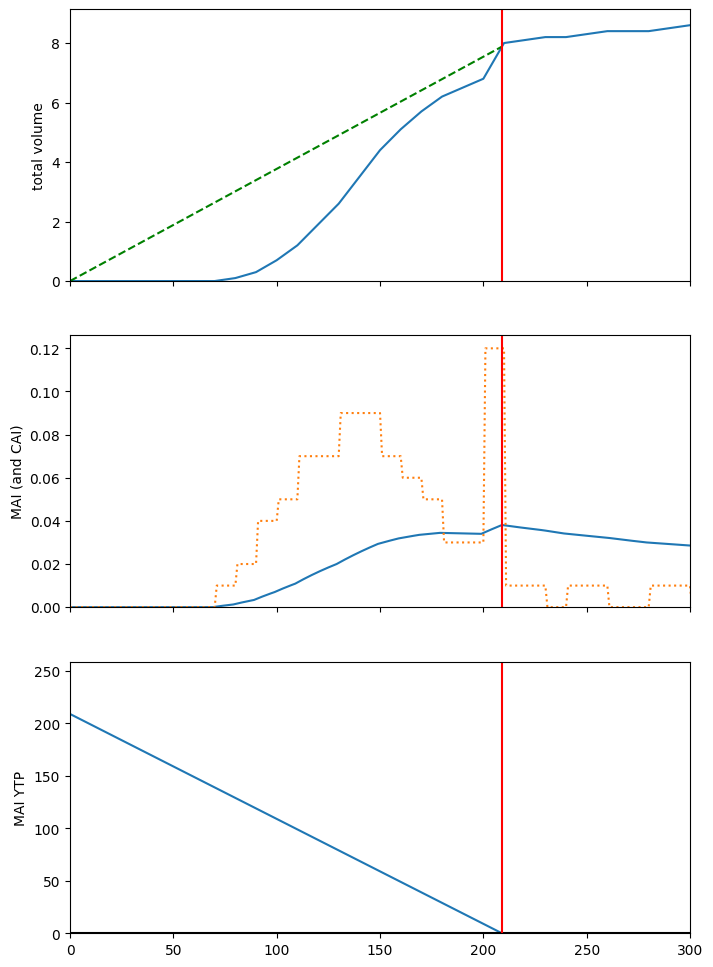

In [31]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

cvol = c
ccai = c.cai()
cmai = c.mai()
cmaiytp = c.mai().ytp()
x_cmai = cmaiytp.lookup(0) # optimal rotation age (i.e., culmination of MAI curve)
labels = 'total volume', 'MAI (and CAI)', 'MAI YTP'

ax[0].plot(*zip(*c.points()))
ax[0].plot([0, x_cmai], [0., cvol[x_cmai]], linestyle='--', color='green')

ax[1].plot(*zip(*c.mai().points()))
ax[1].plot(*zip(*c.cai().points()), linestyle=':')

ax[2].plot(*zip(*c.mai().ytp().points()))
ax[2].axhline(0, color='black')

for i in range(len(ax)):
    ax[i].set_ylabel(labels[i])
    ax[i].set_ylim(0, None)
    ax[i].axvline(x_cmai, color='red')
plt.xlim(0, 300)

## Carbon curves

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import ws3.forest
import time
import gurobipy as grb
import pickle
import os
from util import compile_scenario_maxstock, plot_scenario_maxstock, run_cbm_emissionstock, cbm_report, plugin_c_curves, compare_ws3_cbm, compile_events, cbm_report_both, compare_ws3_cbm_both

In [ ]:
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()
fm.grow()

In [ ]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [ ]:
sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
                                       hardwood_volume_yname='hwdvol', 
                                       admin_boundary='British Columbia', 
                                       eco_boundary='Montane Cordillera',
                                       disturbance_type_mapping=disturbance_type_mapping,
                                       include_empty_dtypes=True)

In [ ]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm_emissionstock(sit_config, sit_tables, n_steps)

In [ ]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                    
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [ ]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]

decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

In [ ]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
total_emission = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']
sum_fluxes = ['total_emission', 'gross_growth', 'net_emission']

In [ ]:
def cbm_report(fm, cbm_output, biomass_pools, dom_pools, total_emission, gross_growth, production, n_steps):
    
    # Add carbon pools indicators 
    pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    annual_carbon_stock = pd.DataFrame({'Year': pi['timestep'],
                                        'Biomass': pi[biomass_pools].sum(axis=1),
                                        'DOM': pi[dom_pools].sum(axis=1),
                                        'Ecosystem': pi[biomass_pools + dom_pools].sum(axis=1)})

    fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    annual_all_emission = pd.DataFrame({'Year': fi['timestep'],
                                        'All_Emissions': fi[total_emission].sum(axis=1)})

    # Calculating gross growth fluxes
    annual_gross_growth = pd.DataFrame({'Year': fi['timestep'],
                                        'Gross_Growth': fi[gross_growth].sum(axis=1)})
    
    # Calculating HWPs carbon
    annual_harvested_carbon = pd.DataFrame({'Year': fi['timestep'],
                                            'Harvested_Carbon': fi[production].sum(axis=1)})


    # Calculating net emissions (All_Emissions - Gross_Growth)
    annual_net_emission = pd.DataFrame({'Year': fi['timestep'],
                                        'Net_Emissions': annual_all_emission['All_Emissions'] - annual_gross_growth['Gross_Growth']})

    df_cs = annual_carbon_stock.groupby('Year').sum()
    df_ae = annual_all_emission.groupby('Year').sum()
    df_gg = annual_gross_growth.groupby('Year').sum()  # Updated to Gross Growth
    df_ne = annual_net_emission.groupby('Year').sum()
    df_hc = annual_harvested_carbon.groupby('Year').sum()

    # Merging all dataframes, now including net emissions and gross growth
    merged_df = pd.merge(pd.merge(pd.merge(pd.merge(df_cs, df_ae, left_index=True, right_index=True, how='outer'),
                                           df_gg, left_index=True, right_index=True, how='outer'),
                                  df_ne, left_index=True, right_index=True, how='outer'),
                         df_hc, left_index=True, right_index=True, how='outer')

    # Calculating stock change
    merged_df['Stock_Change'] = merged_df['Ecosystem'].diff() * (-1)
    merged_df.at[0, 'Stock_Change'] = 0

    # Calculating (Stock Change - Harvested Carbon)
    merged_df['Stock_Change_minus_Harvested_Carbon'] = merged_df['Stock_Change'] - merged_df['Harvested_Carbon']

    # Plotting the graphs
    fig, axs = plt.subplots(8, 1, figsize=(10, 40))

    # Plot 1: Biomass Stock
    axs[0].plot(merged_df.index, merged_df['Biomass'], label='Biomass Stock', color='green')
    axs[0].set_title("Annual Biomass Stock")
    axs[0].set_xlabel("Year")
    axs[0].set_ylabel("Stock (ton C)")
    axs[0].set_xlim(0, n_steps)

    # Plot 2: DOM Stock
    axs[1].plot(merged_df.index, merged_df['DOM'], label='DOM Stock', color='brown')
    axs[1].set_title("Annual DOM Stock")
    axs[1].set_xlabel("Year")
    axs[1].set_ylabel("Stock (ton C)")
    axs[1].set_xlim(0, n_steps)

    # Plot 3: Ecosystem Stock
    axs[2].plot(merged_df.index, merged_df['Ecosystem'], label='Ecosystem Stock', color='blue')
    axs[2].set_title("Annual Ecosystem Stock")
    axs[2].set_xlabel("Year")
    axs[2].set_ylabel("Stock (ton C)")
    axs[2].set_xlim(0, n_steps)

    # Plot 4: All Emissions
    axs[3].plot(merged_df.index, merged_df['All_Emissions'], label='All Emissions', color='red')
    axs[3].set_title("Annual Total Ecosystem Carbon Emissions")
    axs[3].set_xlabel("Year")
    axs[3].set_ylabel("Emissions (ton C)")
    axs[3].set_xlim(0, n_steps)

    # Plot 5: Gross Growth
    axs[4].plot(merged_df.index, merged_df['Gross_Growth'], label='Gross Growth', color='purple')
    axs[4].set_title("Annual Gross Growth")
    axs[4].set_xlabel("Year")
    axs[4].set_ylabel("Growth (ton C)")
    axs[4].set_xlim(0, n_steps)

    # Plot 6: Net Emissions
    axs[5].plot(merged_df.index, merged_df['Net_Emissions'], label='Net Emissions', color='orange')
    axs[5].set_title("Annual Net Ecosystem Carbon Emissions")
    axs[5].set_xlabel("Year")
    axs[5].set_ylabel("Emissions (ton C)")
    axs[5].set_xlim(0, n_steps)

    # Plot 7: Stock Change
    axs[6].plot(merged_df.index, merged_df['Stock_Change'], label='Stock Change', color='cyan')
    axs[6].set_title("Annual Ecosystem Carbon Stock Change")
    axs[6].set_xlabel("Year")
    axs[6].set_ylabel("Stock Change (ton C)")
    axs[6].set_xlim(0, n_steps)

    # Plot 8: Harvested Carbon
    axs[7].plot(merged_df.index, merged_df['Harvested_Carbon'], label='Harvested Carbon', color='magenta')
    axs[7].set_title("Annual Harvested Carbon")
    axs[7].set_xlabel("Year")
    axs[7].set_ylabel("Harvested Carbon (ton C)")
    axs[7].set_xlim(0, n_steps)

    # Comparison plot for Net Emissions vs (Stock Change - Harvested Carbon)
    plt.figure(figsize=(10, 6))
    plt.plot(merged_df.index, merged_df['Net_Emissions'], label='Net Emissions', color='orange', linestyle='--')
    plt.plot(merged_df.index, merged_df['Stock_Change_minus_Harvested_Carbon'], 
             label='Stock Change - Harvested Carbon', color='blue')
    plt.title("Comparison of Annual Net Emissions and Annual (Stock Change - Harvested Carbon)")
    plt.xlabel("Year")
    plt.ylabel("Carbon (ton C)")
    plt.legend()

    # Tight layout for better spacing
    plt.tight_layout()
    plt.show()

    return merged_df

### No-harvesting

In [ ]:
cbm_report(fm, cbm_output, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, n_steps)

## Generate and Add Carbon Yield Curves

Rebuild the inventory table. Set age to 1 and area to 1.0 ha.

The `sit_events` table should be empty.

In [ ]:
sit_yield = sit_tables['sit_yield']


In [ ]:
sit_events = sit_tables['sit_events']

In [ ]:
sit_inventory = sit_tables['sit_inventory']

In [ ]:
# Set Age and Area to 1 and 1.0
df = sit_inventory
df['age'] = df['age'].apply(lambda x: 1)
df['area'] = df['area'].apply(lambda x: 1.0)
df = df.drop_duplicates(ignore_index=True)

Use the following code if any of the developments have no harvesting circumstances.

In [ ]:
# # Replace the Sit Inventory File in the Sit Table
sit_tables['sit_inventory'] = df

In [ ]:
# Run CBM and Generate CBM 0utputs
cbm_output_curves = run_cbm_emissionstock(sit_config, sit_tables, n_steps=700)

In [ ]:
# Generate Carbon Pool and Flux Indicators
pi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.pools.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])
fi = cbm_output_curves.classifiers.to_pandas().merge(cbm_output_curves.flux.to_pandas(), 
                                              left_on=["identifier", "timestep"], 
                                              right_on=["identifier", "timestep"])

In [ ]:
# Define Development Type Keys
pi['dtype_key'] = pi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)
fi['dtype_key'] = fi.apply(lambda r: '%s %s %s %s %s %s' % (r['theme0'], r['theme1'], r['theme2'], r['theme3'], r['theme4'], r['theme5']), axis=1)

In [ ]:
# Generate Carbon Pool anf Flux Curves
c_curves_p = pi.groupby(['dtype_key', 'timestep'], as_index=True)[ecosystem_pools].sum()
c_curves_f = fi.groupby(['dtype_key', 'timestep'], as_index=True)[all_fluxes].sum()

In [ ]:
# Generate sum carbon pool curves
c_curves_p['ecosystem'] = c_curves_p[ecosystem_pools].sum(axis=1)
c_curves_p['biomass'] = c_curves_p[biomass_pools].sum(axis=1)
c_curves_p['DOM'] = c_curves_p[dom_pools].sum(axis=1)

In [ ]:
c_curves_f['total_emission'] = 44/12 * c_curves_f[total_emission].sum(axis=1)
c_curves_f['gross_growth'] = 44/12 * c_curves_f[gross_growth].sum(axis=1)
c_curves_f['net_emission'] = c_curves_f['total_emission'] - c_curves_f['gross_growth']

In [ ]:
c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 0] = c_curves_f.loc[c_curves_f.index.get_level_values('timestep') == 1].values

In [ ]:
def plugin_c_curves(fm, c_curves_p, c_curves_f, pools, fluxes):
    # Dictionary to track registered curves for each dtype_key
    registered_curves = {}

    for dtype_key in fm.dtypes:
        dt = fm.dt(dtype_key)
        # mask = ('?', '?', dtype_key[2], '?', dtype_key[4], '?')
        mask = ('?', '?', dtype_key[2], '?', dtype_key[4], dtype_key[5])
        
        for _mask, ytype, curves in fm.yields:
            if _mask != mask: 
                continue  # Only proceed if the mask matches
            # Initialize the tracking of registered curves for the dtype_key if not already done
            if dtype_key not in registered_curves:
                registered_curves[dtype_key] = set()
            # Register pool curves
            pool_data = c_curves_p.loc[' '.join(dtype_key)]
            for yname in pools:
                if yname not in registered_curves[dtype_key]:  # Check if curve is already registered
                    points = list(zip(pool_data.index.values, pool_data[yname]))
                    curve = fm.register_curve(ws3.core.Curve(yname, 
                                                             points=points, 
                                                             type='a', 
                                                             is_volume=False,
                                                             xmax=fm.max_age,
                                                             period_length=fm.period_length))
                    curves.append((yname, curve))
                    dt.add_ycomp('a', yname, curve)

                    # Mark the curve as registered
                    registered_curves[dtype_key].add(yname)

            # Register flux curves
            flux_data = c_curves_f.loc[' '.join(dtype_key)]
            for yname in fluxes:
                if yname not in registered_curves[dtype_key]:  # Check if curve is already registered
                    points = list(zip(flux_data.index.values, flux_data[yname]))
                    curve = fm.register_curve(ws3.core.Curve(yname, 
                                                             points=points, 
                                                             type='a', 
                                                             is_volume=False,
                                                             xmax=fm.max_age,
                                                             period_length=fm.period_length))
                    curves.append((yname, curve))
                    dt.add_ycomp('a', yname, curve)
                    # Mark the curve as registered
                    registered_curves[dtype_key].add(yname)


In [ ]:
# Plug carbon yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f, sum_pools, sum_fluxes)

In [ ]:
def compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, production, plots):
    eco_pools = biomass_pools + dom_pools
    pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])
    fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    df_cbm = pd.DataFrame({
        'period': pi["timestep"] * 0.1, 
        'biomass_stock': pi[biomass_pools].sum(axis=1),
        'dom_stock': pi[dom_pools].sum(axis=1),
        'eco_stock': pi[eco_pools].sum(axis=1),
        'total_emission': 44/12 * fi[total_emission].sum(axis=1),
        'gross_growth': 44/12 * fi[gross_growth].sum(axis=1),
        'harvested_carbon': fi[production].sum(axis=1)
    }).groupby('period').sum().iloc[1::10, :].reset_index()

    df_cbm['period'] = (df_cbm['period'] + 0.9).astype(int)
    df_cbm['net_emission'] = df_cbm['total_emission'] - df_cbm['gross_growth']

    df_ws3 = pd.DataFrame({
        'period': fm.periods,
        'biomass_stock': [fm.inventory(period, 'biomass') for period in fm.periods],
        'dom_stock': [fm.inventory(period, 'DOM') for period in fm.periods],
        'eco_stock': [fm.inventory(period, 'ecosystem') for period in fm.periods],
        'net_emission': [fm.inventory(period, 'net_emission') for period in fm.periods],
        'harvested_carbon': [fm.compile_product(period, 'totvol * 0.85', acode='harvest') * 0.23 for period in fm.periods]
    })


    if plots == "whole":
        # Create a figure for all comparisons in one plot
        plt.figure(figsize=(10, 6))

        # Plotting the ecosystem stock comparison
        plt.plot(df_cbm['period'], df_cbm['eco_stock'], label='CBM Ecosystem Stock')
        plt.plot(df_ws3['period'], df_ws3['eco_stock'], label='WS3 Ecosystem Stock')

        # Plotting the biomass stock comparison
        plt.plot(df_cbm['period'], df_cbm['biomass_stock'], label='CBM Biomass Stock')
        plt.plot(df_ws3['period'], df_ws3['biomass_stock'], label='WS3 Biomass Stock')

        # Plotting the DOM stock comparison
        plt.plot(df_cbm['period'], df_cbm['dom_stock'], label='CBM DOM Stock')
        plt.plot(df_ws3['period'], df_ws3['dom_stock'], label='WS3 DOM Stock')


        # Plotting the harvested carbon comparison
        plt.plot(df_cbm['period'], df_cbm['harvested_carbon'], label='CBM Harvested Carbon')
        plt.plot(df_ws3['period'], df_ws3['harvested_carbon'], label='WS3 Harvested Carbon')


        # Plotting the net ecosystem carbon emission comparison
        plt.plot(df_cbm['period'], df_cbm['net_emission'], label='CBM Net Ecosystem Emission')
        plt.plot(df_ws3['period'], df_ws3['net_emission'], label='WS3 Net Ecosystem Emission')

        # Set labels and title
        plt.xlabel('Period')
        plt.ylabel('Stock (ton C)')
        plt.ylim(0, None)  # Ensure y-axis starts from 0

        # Customize x-axis ticks to show every 2 periods
        ticks = np.arange(df_cbm['period'].min() - 1, df_cbm['period'].max() + 1, 2)
        plt.xticks(ticks)

        # Add a legend to differentiate the lines
        plt.legend()

    if plots == "individual":
        # Create a figure with subplots
        fig, axs = plt.subplots(5, 1, figsize=(10, 16))  # Increase figure size for 7 subplots (added harvested carbon)

        # Define x-axis ticks (0 to 20 with a step of 2)
        ticks = np.arange(df_cbm['period'].min() - 1, df_cbm['period'].max() + 1, 2)

        # Ecosystem stock comparison
        axs[0].plot(df_cbm['period'], df_cbm['eco_stock'], label='CBM Ecosystem Stock')
        axs[0].plot(df_ws3['period'], df_ws3['eco_stock'], label='WS3 Ecosystem Stock')
        axs[0].set_xlabel('Period')
        axs[0].set_ylabel('Stock (ton C)')
        axs[0].set_xticks(ticks)
        axs[0].legend()

        # Biomass stock comparison
        axs[1].plot(df_cbm['period'], df_cbm['biomass_stock'], label='CBM Biomass Stock')
        axs[1].plot(df_ws3['period'], df_ws3['biomass_stock'], label='WS3 Biomass Stock')
        axs[1].set_xlabel('Period')
        axs[1].set_ylabel('Stock (ton C)')
        axs[1].set_xticks(ticks)
        axs[1].legend()

        # DOM stock comparison
        axs[2].plot(df_cbm['period'], df_cbm['dom_stock'], label='CBM DOM Stock')
        axs[2].plot(df_ws3['period'], df_ws3['dom_stock'], label='WS3 DOM Stock')
        axs[2].set_xlabel('Period')
        axs[2].set_ylabel('Stock (ton C)')
        axs[2].set_xticks(ticks)
        axs[2].legend()

        # Harvested carbon comparison
        axs[3].plot(df_cbm['period'], df_cbm['harvested_carbon'], label='CBM Harvested Carbon')
        axs[3].plot(df_ws3['period'], df_ws3['harvested_carbon'], label='WS3 Harvested Carbon')
        axs[3].set_xlabel('Period')
        axs[3].set_ylabel('Harvested Carbon (ton C)')
        axs[3].set_xticks(ticks)
        axs[3].legend()


        # Net ecosystem carbon emission comparison
        axs[4].plot(df_cbm['period'], df_cbm['net_emission'], label='CBM Net Ecosystem Emission')
        axs[4].plot(df_ws3['period'], df_ws3['net_emission'], label='WS3 Net Ecosystem Emission')
        axs[4].set_xlabel('Period')
        axs[4].set_ylabel('Emission (ton C)')
        axs[4].set_xticks(ticks)
        axs[4].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined plot
    plt.show()

    return df_cbm, df_ws3

In [ ]:
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, total_emission, gross_growth, disturbance_production_fluxes, plots='individual')